In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
housing = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0)
housing.shape

(2580, 81)

In [4]:
housing.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,...,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
2,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
3,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
4,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,...,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
5,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,...,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


In [5]:
#create dependent variable
price = housing['SalePrice']

In [6]:
#my housing subset
housing1 = housing[['SalePrice','MSSubClass','MSZoning','LotArea','Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl','GrLivArea']].copy()

In [7]:
#check data types 
housing1.dtypes

SalePrice        int64
MSSubClass       int64
MSZoning        object
LotArea          int64
Street          object
LotShape        object
LandContour     object
Utilities       object
LotConfig       object
LandSlope       object
Neighborhood    object
Condition1      object
Condition2      object
BldgType        object
HouseStyle      object
OverallQual      int64
OverallCond      int64
YearBuilt        int64
YearRemodAdd     int64
RoofStyle       object
RoofMatl        object
GrLivArea        int64
dtype: object

In [8]:
#check for missing variables in subset - None :)
housing1.isnull().any()

SalePrice       False
MSSubClass      False
MSZoning        False
LotArea         False
Street          False
LotShape        False
LandContour     False
Utilities       False
LotConfig       False
LandSlope       False
Neighborhood    False
Condition1      False
Condition2      False
BldgType        False
HouseStyle      False
OverallQual     False
OverallCond     False
YearBuilt       False
YearRemodAdd    False
RoofStyle       False
RoofMatl        False
GrLivArea       False
dtype: bool

## Data cleaning

##### Convert columns to ordinal 

In [9]:
#(LotShape, LotContour, Utilities, LandSlope)
housing1.LotShape.replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)
housing1.LandContour.replace({'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}, inplace=True)
housing1.Utilities.replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)
housing1.LandSlope.replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)

##### Convert MSSubClass column to categorical

In [11]:
housing1['MSSubClass'] = housing1['MSSubClass'].astype(str)

<AxesSubplot:xlabel='Fence', ylabel='SalePrice'>

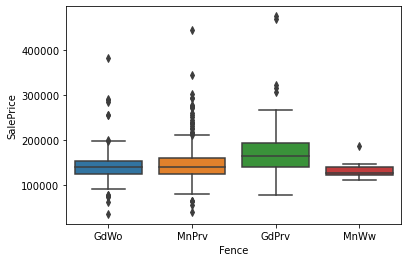

In [12]:
sns.boxplot(y=housing1['SalePrice'], x=housing['Fence'])

#### Create Binary

##### Grouping Roof categories

In [529]:
print(housing1['RoofStyle'].value_counts())
print(housing1['RoofMatl'].value_counts())

Gable      2059
Hip         473
Gambrel      18
Flat         16
Mansard      10
Shed          4
Name: RoofStyle, dtype: int64
CompShg    2544
Tar&Grv      18
WdShake       8
WdShngl       7
Roll          1
Membran       1
Metal         1
Name: RoofMatl, dtype: int64


In [530]:
#make binary - add hip to style?
housing1['RoofStyle']= [1 if x =='Gable' else 0 for x in housing1['RoofStyle']]
housing1['RoofMatl']= [1 if x =='CompShg' else 0 for x in housing1['RoofMatl']]

housing1.rename(columns = {'RoofStyle': 'RoofStyle_Gable', 'RoofMatl': 'RoofMatl_CompShg'}, inplace = True)

Create street binary

In [531]:
housing1['Street']= [1 if x =='Pave' else 0 for x in housing1['Street']]
housing1.rename(columns = {'Street': 'Street_Paved'}, inplace = True)

##### Create dummies

In [532]:
dummies=['MSSubClass','MSZoning','BldgType','LotConfig','HouseStyle']

for d in dummies:
    temp = pd.get_dummies(housing1[d], prefix=d, prefix_sep='__')
    temp = temp.drop(d+'__'+str(housing1[d].mode()[0]), axis=1)
    #drop the most common one (mode), making it the base case
    housing1 = pd.concat([housing1.drop(d, axis=1),temp], axis=1)
    #merge back with main df

### Numerical features

In [535]:
#get numerical features
num_features = housing1.select_dtypes(include=['int64','float64']).columns
num_features = num_features.drop('SalePrice')
num_features

Index(['LotArea', 'Street_Paved', 'LotShape', 'LandContour', 'Utilities',
       'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle_Gable', 'RoofMatl_CompShg', 'GrLivArea'],
      dtype='object')

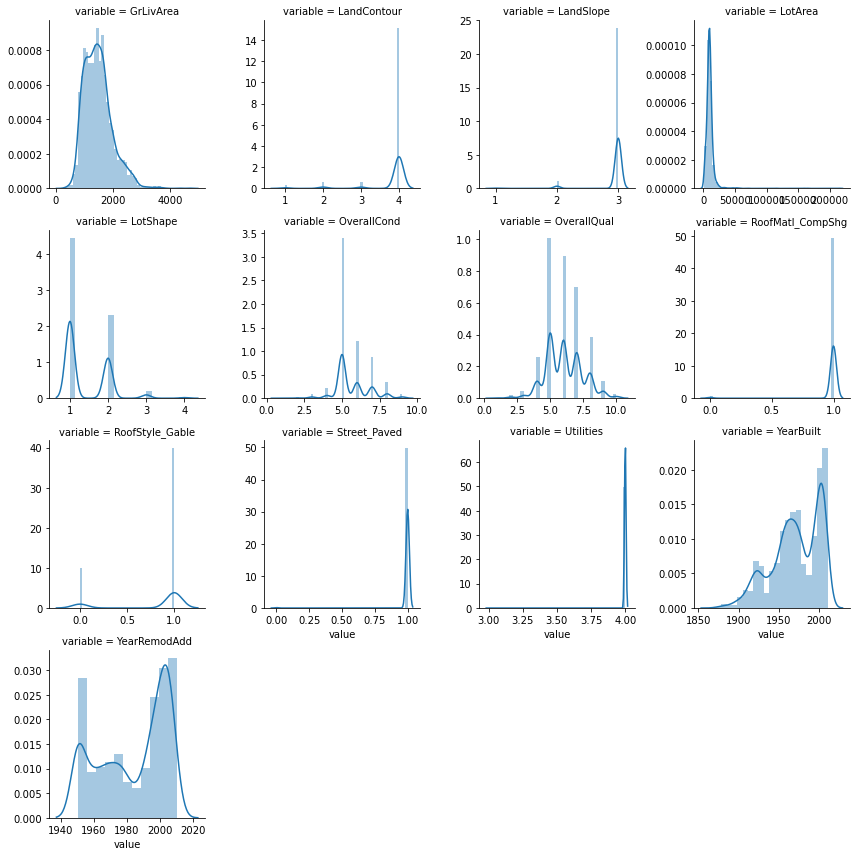

In [536]:
f = pd.melt(housing1, value_vars=sorted(num_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, 'value')

#### Transforming data that appears to be skewed

In [282]:
#LotArea
print("original skew: " + str(housing1['LotArea'].skew()))
loglot=np.log(housing1['LotArea'])
print("after log transformation: " + str(loglot.skew()))

original skew: 12.207687851233496
after log transformation: -0.1379938086958118


<AxesSubplot:xlabel='LotArea', ylabel='Count'>

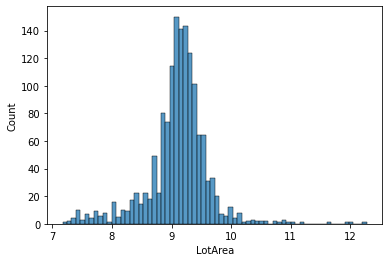

In [283]:
sns.histplot(np.log(housing1['LotArea']))

In [284]:
#GrLivArea
print("original skew: " + str(housing1['GrLivArea'].skew()))
logGrLiv = np.log(housing1['GrLivArea'])
print("after log transformation: " + str(logGrLiv.skew()))

original skew: 1.3665603560164552
after log transformation: -0.006995182187690808


<AxesSubplot:xlabel='GrLivArea', ylabel='Count'>

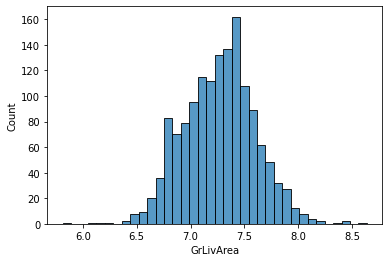

In [285]:
sns.histplot(np.log(housing1['GrLivArea']))

#### remove outliers

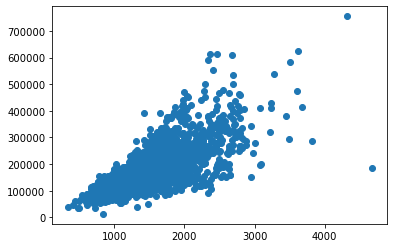

In [545]:
plt.scatter(x=housing1['GrLivArea'], y=housing1['SalePrice'])

In [546]:
housing1.drop(housing1[housing1["GrLivArea"] > 4000].index, inplace = True)

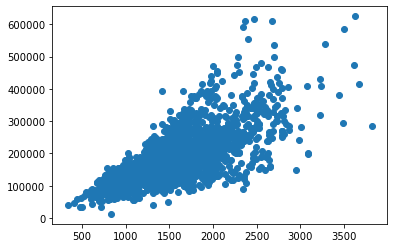

In [547]:
plt.scatter(x=housing1['GrLivArea'], y=housing1['SalePrice'])

#### Check correlations of numerical data

<AxesSubplot:>

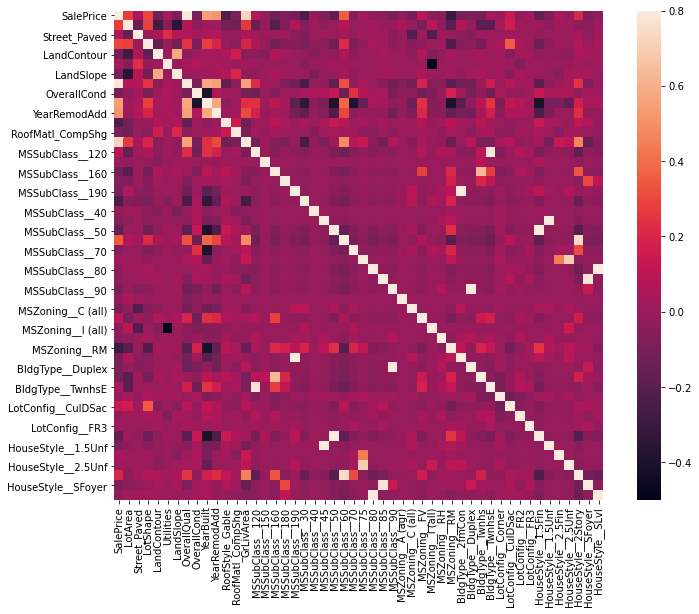

In [543]:
#check correlations using heat map
corr = housing1.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True)

Overall Quality and Sale Price appear to be highly correlated

In [554]:
#check numerical correlations to sale price
housing1.corr()['SalePrice'].sort_values(ascending=False).head(15)

SalePrice             1.000000
OverallQual           0.793255
GrLivArea             0.721445
YearBuilt             0.548186
YearRemodAdd          0.518285
MSSubClass__60        0.352925
LotShape              0.295001
LotArea               0.274355
HouseStyle__2Story    0.202013
LotConfig__CulDSac    0.146055
MSZoning__FV          0.111227
MSSubClass__120       0.090102
Street_Paved          0.050893
HouseStyle__2.5Fin    0.042242
BldgType__TwnhsE      0.038354
Name: SalePrice, dtype: float64

#### What's left:
##### Condition categories -  can we drop? Neighborhoods?

If were looking at just profiting off house features we dont need these?

In [540]:
categ_features = housing1.select_dtypes(include=['object']).columns
categ_features

Index(['Neighborhood', 'Condition1', 'Condition2'], dtype='object')

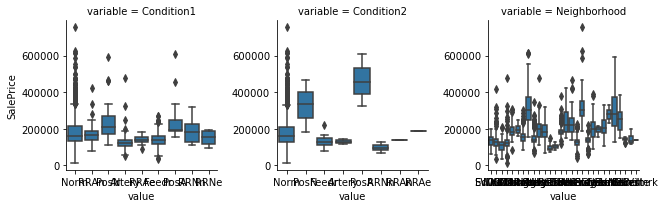

In [541]:
f = pd.melt(housing1, id_vars= ['SalePrice'], value_vars=sorted(categ_features))
g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.boxplot, 'value', 'SalePrice')

In [548]:
housing1['Condition1'].value_counts()

Norm      2223
Feedr      137
Artery      81
RRAn        40
PosN        36
RRAe        26
PosA        19
RRNn         8
RRNe         4
Name: Condition1, dtype: int64

In [549]:
housing1['Condition2'].value_counts()

Norm      2550
Feedr       12
Artery       3
PosA         3
PosN         2
RRNn         2
RRAn         1
RRAe         1
Name: Condition2, dtype: int64

<AxesSubplot:xlabel='Condition1', ylabel='SalePrice'>

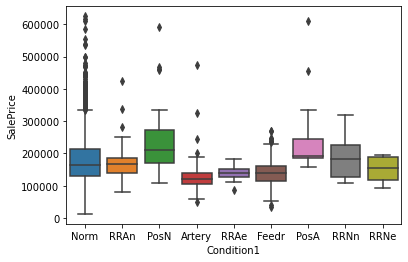

In [550]:
sns.boxplot(y=housing1['SalePrice'], x=housing1['Condition1'])

In [552]:
print(housing1['Neighborhood'].value_counts())

NAmes      410
CollgCr    235
OldTown    212
Edwards    164
Somerst    143
Gilbert    143
Sawyer     139
NWAmes     123
NridgHt    121
SawyerW    113
Mitchel    104
BrkSide    103
Crawfor     93
IDOTRR      76
NoRidge     66
Timber      54
StoneBr     43
SWISU       41
ClearCr     40
MeadowV     34
BrDale      29
Veenker     23
NPkVill     22
Blmngtn     22
Blueste     10
Greens       8
GrnHill      2
Landmrk      1
Name: Neighborhood, dtype: int64


#### Tried F test

In [561]:
Ftestdata = housing1.drop(['Neighborhood','Condition1','Condition2','SalePrice'], axis=1)

In [563]:
from sklearn.feature_selection import f_regression
F_values, p_values = f_regression(Ftestdata, housing1['SalePrice'])

pd.Series(p_values, index=Ftestdata.columns).sort_values()

OverallQual            0.000000e+00
GrLivArea              0.000000e+00
YearBuilt             7.048451e-202
YearRemodAdd          5.896115e-177
MSSubClass__60         2.256790e-76
MSZoning__RM           3.696801e-55
LotShape               7.498321e-53
LotArea                1.125170e-45
MSSubClass__30         2.604180e-35
RoofStyle_Gable        4.176185e-32
HouseStyle__2Story     4.142581e-25
HouseStyle__1.5Fin     2.734615e-19
MSSubClass__50         1.846759e-17
LotConfig__CulDSac     9.591353e-14
MSSubClass__160        8.955003e-10
LandContour            4.250525e-09
MSZoning__FV           1.532489e-08
BldgType__Twnhs        3.291966e-08
MSZoning__C (all)      5.647108e-08
BldgType__2fmCon       1.453367e-07
OverallCond            1.847081e-07
MSSubClass__190        2.275369e-07
MSSubClass__90         2.636549e-06
BldgType__Duplex       2.636549e-06
MSSubClass__120        4.685323e-06
LandSlope              4.326696e-05
HouseStyle__1.5Unf     5.697091e-05
HouseStyle__SFoyer     1.065